# Mergers and groups with Galaxy Zoo 1 and Galaxy Zoo 2

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang, specifically looking at mergers classified by both GZ1 and GZ2.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "Data\Group_data_full_GZ1_GZ2_no_z.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# gz2_data = gz2_data[(gz2_data["REDSHIFT"] >= 0.01) & (gz2_data["REDSHIFT"] <= 0.2)]

# Display head of data
display(all_data[0:5])

gz1_gz2_data = all_data[(all_data["GZ1"] == 1) | (all_data["GZ2"] == 1)]
gz1_spectro = all_data[all_data["GZ1_Table2"] == 1]
gz1_photo = all_data[all_data["GZ1_Table3"] == 1]
gz2_spectro = all_data[all_data["GZ2_main_spectroz"] == 1]
gz2_spectro = gz2_spectro[(gz2_spectro["REDSHIFT"] >= 0.01) & (gz2_spectro["REDSHIFT"] <= 0.2)]
gz2_photo = all_data[all_data["GZ2_main_photoz"] == 1]

galaxy ID_1_1,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,galaxy id_2,galaxy id in NYU_VAGC,group id_1,brightest galaxy,most massive galaxy,group id_2,member galaxy id in NYU_VAGC,member galaxy id in SDSS7,group id,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,GroupID_topcat,GroupSize_topcat,group_size,specobjid,dr8objid,dr7objid,ra,dec,rastring,decstring,sample,gz2class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_roun

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [2]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[all_data_pandas["P_MG"] > 0.4, "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)

### Matching classifications of mergers

Now we have identified mergers in both GZ1 and GZ2 data, we are interested in how galaxies that appear in both data sets are classified. We would hope that galaxies identified in one data set as mergers and also mergers in the other data set.

We will create a new column that is the sum of "GZ1_merger_yes" and "GZ2_merger_yes". This will have the value of 2 if the galaxy is a merger in both data sets, 1 if a merger in one data set but not the other, and 0 if it is not a merger in either data set.

In [3]:
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

print("Number of galaxies classified as mergers: " + str(len(all_data[all_data["Merger_classifications"] > 0])))
print("Number of galaxies classified as mergers in GZ1: " + str(len(all_data[all_data["GZ1_merger_yes"] == 1])))
print("Number of galaxies classified as mergers in GZ2: " + str(len(all_data[all_data["GZ2_merger_yes"] == 1])))
print("Number of galaxies classified as mergers in GZ1 and GZ2: " + str(len(all_data[all_data["Merger_classifications"] == 2])))

print("Number of galaxies classified as mergers in GZ1 but not GZ2: " + str(len(all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & (all_data["GZ1_merger_yes"] == 1) & (all_data["GZ2_merger_yes"] == 0)])))
print("Number of galaxies classified as mergers in GZ2 but not GZ1: " + str(len(all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & (all_data["GZ1_merger_yes"] == 0) & (all_data["GZ2_merger_yes"] == 1)])))

Number of galaxies classified as mergers: 17919
Number of galaxies classified as mergers in GZ1: 12749
Number of galaxies classified as mergers in GZ2: 9909
Number of galaxies classified as mergers in GZ1 and GZ2: 4739
Number of galaxies classified as mergers in GZ1 but not GZ2: 1290
Number of galaxies classified as mergers in GZ2 but not GZ1: 5152


In total these thresholds for GZ1 and GZ2 have classified 17919 galaxies as mergers, with 4739 in both GZ1 and GZ2. However, there are galaxies that are classified in one data set but not the other; 1290 are classified as mergers in GZ1 but not in GZ2 and 5152 are classified as mergers in GZ2 but not in GZ1. We will look at these in further detail.

### All mergers
First we will plot all the mergers on a single graph, coloured by how they are classified. All galaxies classified in both GZ1 and GZ2 will be in one colour, all galaxies classified in GZ1 but not GZ2 will be in another colour, and all galaxies classified in GZ2 but not GZ1 will be in another.

We plot the GZ1 merger vote fraction against each of the four GZ2 thresholds, to get an idea of which criteria galaxies fail to meet. We include dashed lines to indicate the threshold for the GZ1 and GZ2 criteria.

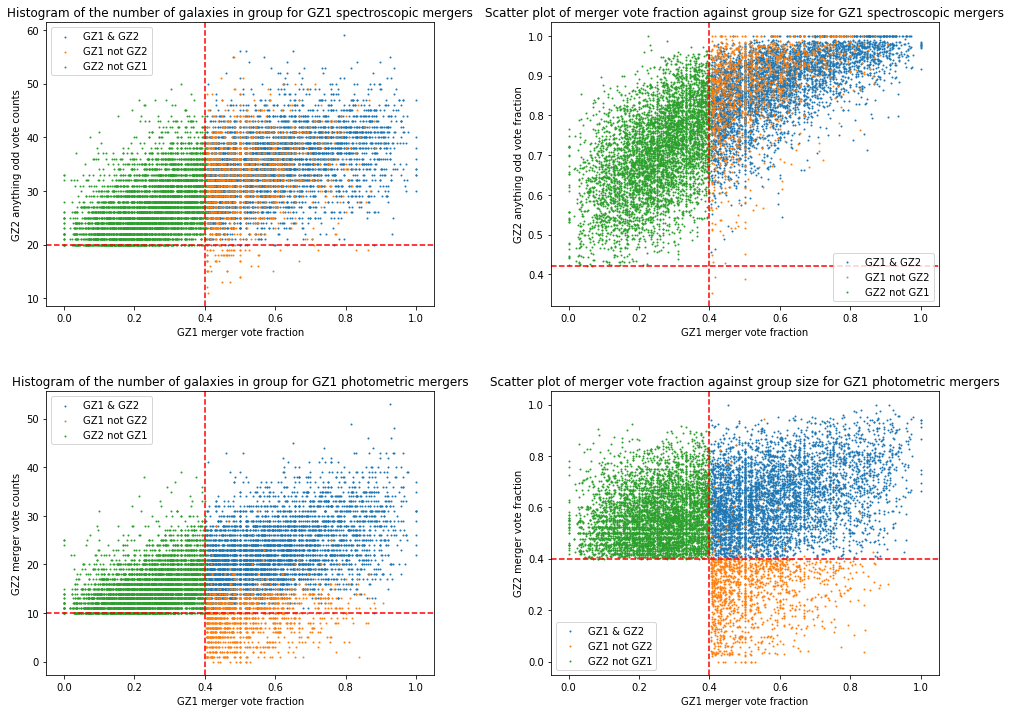

In [4]:
gz1_or_gz2_mergers = all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & ((all_data["GZ1_merger_yes"] == 1) | (all_data["GZ2_merger_yes"] == 1))]
gz1_and_gz2_mergers = all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & (all_data["GZ1_merger_yes"] == 1) & (all_data["GZ2_merger_yes"] == 1)]
gz1_not_gz2_mergers = all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & (all_data["GZ1_merger_yes"] == 1) & (all_data["GZ2_merger_yes"] == 0)]
gz2_not_gz1_mergers = all_data[(all_data["GZ1"] == 1) & (all_data["GZ2"] == 1) & (all_data["GZ1_merger_yes"] == 0) & (all_data["GZ2_merger_yes"] == 1)]

fig, ax = plt.subplots(2, 2, figsize=(16,12))

# Plot histogram of group size for galaxies classified as mergers
ax[0, 0].scatter(gz1_and_gz2_mergers["P_MG"], gz1_and_gz2_mergers["t06_odd_a14_yes_count"], label="GZ1 & GZ2", s=1)
ax[0, 0].scatter(gz1_not_gz2_mergers["P_MG"], gz1_not_gz2_mergers["t06_odd_a14_yes_count"], label="GZ1 not GZ2", s=1)
ax[0, 0].scatter(gz2_not_gz1_mergers["P_MG"], gz2_not_gz1_mergers["t06_odd_a14_yes_count"], label="GZ2 not GZ1", s=1)
ax[0, 0].axvline(x=0.4, linestyle="--", c="red")
ax[0, 0].axhline(y=20, linestyle="--", c="red")
ax[0, 0].set_xlabel("GZ1 merger vote fraction")
ax[0, 0].set_ylabel("GZ2 anything odd vote counts")
ax[0, 0].legend()
ax[0, 0].set_title("Histogram of the number of galaxies in group for GZ1 spectroscopic mergers")

# Plot scatter plot of merger vote fraction against group size, for galaxies classified as mergers
ax[0, 1].scatter(gz1_and_gz2_mergers["P_MG"], gz1_and_gz2_mergers["t06_odd_a14_yes_debiased"], label="GZ1 & GZ2", s=1)
ax[0, 1].scatter(gz1_not_gz2_mergers["P_MG"], gz1_not_gz2_mergers["t06_odd_a14_yes_debiased"], label="GZ1 not GZ2", s=1)
ax[0, 1].scatter(gz2_not_gz1_mergers["P_MG"], gz2_not_gz1_mergers["t06_odd_a14_yes_debiased"], label="GZ2 not GZ1", s=1)
ax[0, 1].axvline(x=0.4, linestyle="--", c="red")
ax[0, 1].axhline(y=0.42, linestyle="--", c="red")
ax[0, 1].set_xlabel("GZ1 merger vote fraction")
ax[0, 1].set_ylabel("GZ2 anything odd vote fraction")
ax[0, 1].legend()
ax[0, 1].set_title("Scatter plot of merger vote fraction against group size for GZ1 spectroscopic mergers")

# Plot histogram of group size for galaxies classified as mergers
ax[1, 0].scatter(gz1_and_gz2_mergers["P_MG"], gz1_and_gz2_mergers["t08_odd_feature_a24_merger_count"], label="GZ1 & GZ2", s=1)
ax[1, 0].scatter(gz1_not_gz2_mergers["P_MG"], gz1_not_gz2_mergers["t08_odd_feature_a24_merger_count"], label="GZ1 not GZ2", s=1)
ax[1, 0].scatter(gz2_not_gz1_mergers["P_MG"], gz2_not_gz1_mergers["t08_odd_feature_a24_merger_count"], label="GZ2 not GZ1", s=1)
ax[1, 0].axvline(x=0.4, linestyle="--", c="red")
ax[1, 0].axhline(y=10, linestyle="--", c="red")
ax[1, 0].set_xlabel("GZ1 merger vote fraction")
ax[1, 0].set_ylabel("GZ2 merger vote counts")
ax[1, 0].legend()
ax[1, 0].set_title("Histogram of the number of galaxies in group for GZ1 photometric mergers")

# Plot scatter plot of merger vote fraction against group size, for galaxies classified as mergers
ax[1, 1].scatter(gz1_and_gz2_mergers["P_MG"], gz1_and_gz2_mergers["t08_odd_feature_a24_merger_debiased"], label="GZ1 & GZ2", s=1)
ax[1, 1].scatter(gz1_not_gz2_mergers["P_MG"], gz1_not_gz2_mergers["t08_odd_feature_a24_merger_debiased"], label="GZ1 not GZ2", s=1)
ax[1, 1].scatter(gz2_not_gz1_mergers["P_MG"], gz2_not_gz1_mergers["t08_odd_feature_a24_merger_debiased"], label="GZ2 not GZ1", s=1)
ax[1, 1].axvline(x=0.4, linestyle="--", c="red")
ax[1, 1].axhline(y=0.4, linestyle="--", c="red")
ax[1, 1].set_xlabel("GZ1 merger vote fraction")
ax[1, 1].set_ylabel("GZ2 merger vote fraction")
ax[1, 1].legend()
ax[1, 1].set_title("Scatter plot of merger vote fraction against group size for GZ1 photometric mergers")

fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

We see a general upward trend in the graphs; galaxies with higher merger vote fractions in GZ1 ten to also have higher vote counts and vote fractions in GZ2.

The blue points are galaxies which pass both the GZ1 and GZ2 criteria, so we see them in the top right each of the graphs.

The green points are galaxies which are classified as mergers in GZ2 but not GZ1, so they all lie in the top left of each graph.

The orange points are galaxies which are classified as mergers in GZ1 but not GZ2, so lie on the right of each graph. These are not constrained to just the bottom right of each graph, as galaxies must fail only one GZ2 threshold to not be classified as a merger. From the first two plots, we can see that most of the orange points lie above the GZ2 threshold line, so in general are not failing these criteria. Almost all of the orange points fail to pass the threshold on GZ2 merger vote fraction however, and most fail the threshold on GZ2 merger vote counts, so these two criteria are the most strict.

### Strong classifications
The most interesting galaxies are the ones strongly classified as mergers in one data set, but not classified in the other. These are the points near GZ1 merger vote fraction $p_\text{merger, GZ1} = 1$, and the points with a high number of GZ2 merger vote counts and high GZ2 merger vote fractions, $p_\text{merger, GZ2}$. We would like to visually inspect these galaxies to see what they look like.

#### GZ1 mergers not classified as GZ2 mergers
We first look at mergers with high merger vote fractions in GZ1.

In [5]:
print("Number of GZ1 mergers & not GZ2 mergers with merger vote fraction >= 0.8: " + str(len(gz1_not_gz2_mergers[gz1_not_gz2_mergers["P_MG"] >= 0.8])))

Number of GZ1 mergers & not GZ2 mergers with merger vote fraction >= 0.8: 29


ra,dec,P_MG,t06_odd_a14_yes_count,t06_odd_a14_yes_debiased,t08_odd_feature_a24_merger_count,t08_odd_feature_a24_merger_debiased
float32,float32,float32,int16,float32,int16,float32
193.9154,0.17478377,0.806,34,1.0,11,0.324
232.8874,-0.5262934,0.8,44,0.91246,17,0.386
242.68147,49.265614,0.808,40,0.8645455,16,0.390695
247.34378,48.87102,0.8,34,0.9486276,10,0.286
144.43394,2.7608206,0.88,43,0.977,12,0.285
165.2684,4.545926,0.817,31,0.9135502,9,0.34717053
146.60251,50.417297,0.833,45,0.932945,17,0.37
127.226364,34.65166,0.867,42,0.8828778,13,0.31
195.79907,55.673946,0.828,19,0.7641406,11,0.579


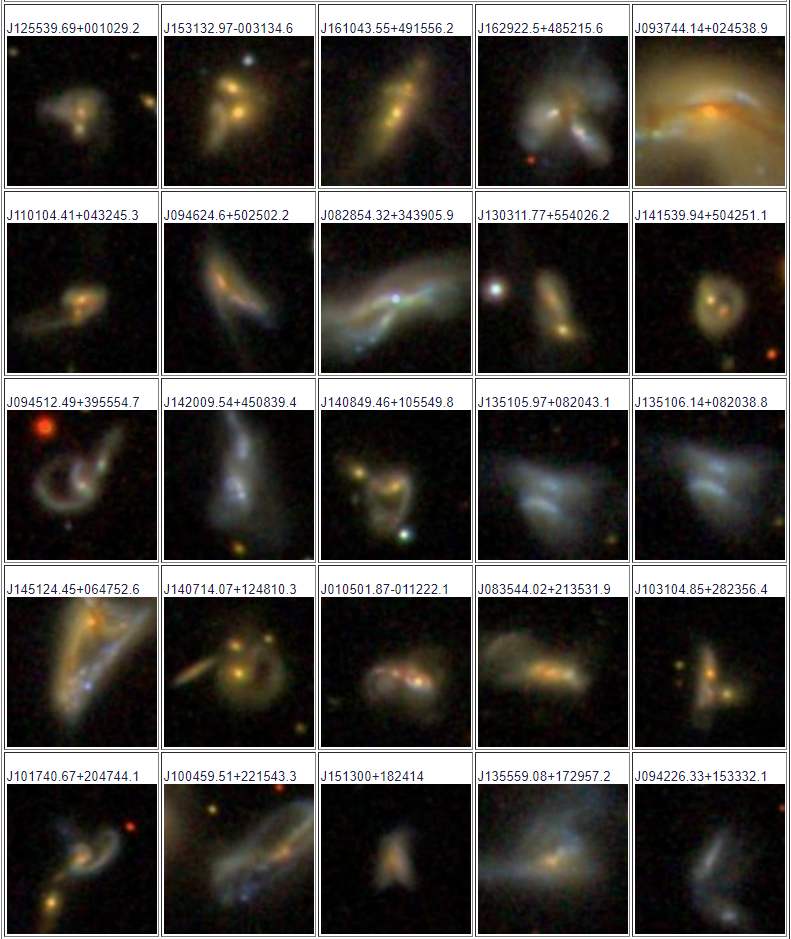

In [6]:
display(gz1_not_gz2_mergers[gz1_not_gz2_mergers["P_MG"] >= 0.8]["ra", "dec", "P_MG", "t06_odd_a14_yes_count", "t06_odd_a14_yes_debiased", "t08_odd_feature_a24_merger_count", "t08_odd_feature_a24_merger_debiased"])

from PIL import Image

pil_im = Image.open('Data\\Pics\\gz1_not_gz2_mergers.png', 'r')
display(pil_im)

#### GZ2 mergers not classified as GZ1 mergers
We now look at galaxies with high merger vote counts in GZ2.

In [7]:
print("Number of GZ2 mergers & not GZ1 mergers with merger vote counts >= 30: " + str(len(gz2_not_gz1_mergers[gz2_not_gz1_mergers["t08_odd_feature_a24_merger_count"] >= 30])))

Number of GZ2 mergers & not GZ1 mergers with merger vote counts >= 30: 34


ra,dec,P_MG,t06_odd_a14_yes_count,t06_odd_a14_yes_debiased,t08_odd_feature_a24_merger_count,t08_odd_feature_a24_merger_debiased
float32,float32,float32,int16,float32,int16,float32
175.16234,-0.3059516,0.393,42,0.8517832,33,0.76326406
195.4314,3.2676158,0.273,43,0.9371321,33,0.775
171.3059,2.5794775,0.22,44,0.83728546,31,0.715
223.11977,4.4620028,0.361,48,0.9148828,32,0.6580702
143.4149,1.2957436,0.4,42,0.8247062,30,0.7052581
117.36975,33.851254,0.32,38,0.8948577,31,0.816
247.47856,45.64113,0.359,41,0.89135313,34,0.829
227.37018,5.3345504,0.315,43,0.87422353,37,0.86
130.41997,40.650604,0.375,43,0.915,38,0.884


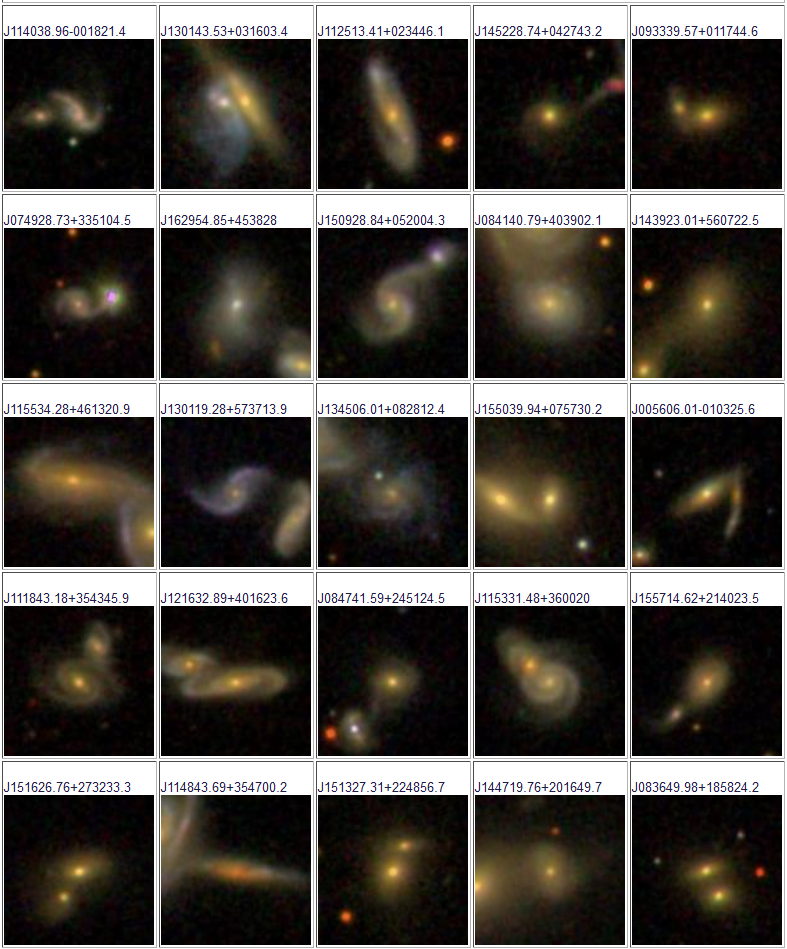

In [8]:
display(gz2_not_gz1_mergers[gz2_not_gz1_mergers["t08_odd_feature_a24_merger_count"] >= 30]["ra", "dec", "P_MG", "t06_odd_a14_yes_count", "t06_odd_a14_yes_debiased", "t08_odd_feature_a24_merger_count", "t08_odd_feature_a24_merger_debiased"])

pil_im = Image.open('Data\\Pics\\gz2_not_gz1_mergers.png', 'r')
display(pil_im)